# Modeling a roulette wheel in vanilla Python

The first thing to do is model the possible results.  The places where the ball can settle are called "pockets."  American roulette has two green pockets call "0" and "00."  I'm going to lazily label the double zero pocket as -1 for now.  The rest of the pockets are evenly (though irregularly) divided between red and black.

In [563]:
from random import choice

In [564]:
class RouletteWheel:
    POCKETS =(
        (-1, 'green'),
        (0, 'green'),
        (1, 'red'),
        (2, 'black'),
        (3, 'red'),
        (4, 'black'),
        (5, 'red'),
        (6, 'black'),
        (7, 'red'),
        (8, 'black'),
        (9, 'red'),
        (10, 'black'),
        (11, 'black'),
        (12, 'red'),
        (13, 'black'),
        (14, 'red'),
        (15, 'black'),
        (16, 'red'),
        (17, 'black'),
        (18, 'red'),
        (19, 'red'),
        (20, 'black'),
        (21, 'red'),
        (22, 'black'),
        (23, 'red'),
        (24, 'black'),
        (25, 'red'),
        (26, 'black'),
        (27, 'red'),
        (28, 'black'),
        (29, 'black'),
        (30, 'red'),
        (31, 'black'),
        (32, 'red'),
        (33, 'black'),
        (34, 'red'),
        (35, 'black'),
        (36, 'red'))
    
    def spin(self):
        return choice(self.POCKETS)

Here's an example of calling `random.choice()` with the `POCKETS` we defined above.

In [565]:
theWheel = RouletteWheel()
print(
    theWheel.spin(),
    theWheel.spin(),
    theWheel.spin(),)

(25, 'red') (22, 'black') (32, 'red')


In [566]:
from collections import Counter

In [567]:
million_spins = tuple(theWheel.spin() for _ in range(1_000_000))
million_spin_frequencies = sorted(Counter(million_spins).most_common())
print("Pocket\tFrequency")
for pocket in million_spin_frequencies:
    print(f"{pocket[0][0]}\t{pocket[1]:,g}")

Pocket	Frequency
-1	26,430
0	26,647
1	26,437
2	26,280
3	26,155
4	26,273
5	26,232
6	26,258
7	26,189
8	26,444
9	26,443
10	26,452
11	26,403
12	26,297
13	26,217
14	26,357
15	26,112
16	25,821
17	26,323
18	26,151
19	26,358
20	26,545
21	26,434
22	26,383
23	26,319
24	26,393
25	26,508
26	26,562
27	26,375
28	26,298
29	25,971
30	26,184
31	26,382
32	26,545
33	26,042
34	26,197
35	26,229
36	26,354


The table's a bit long, perhaps a graph?

In [568]:
import matplotlib.pyplot as plt

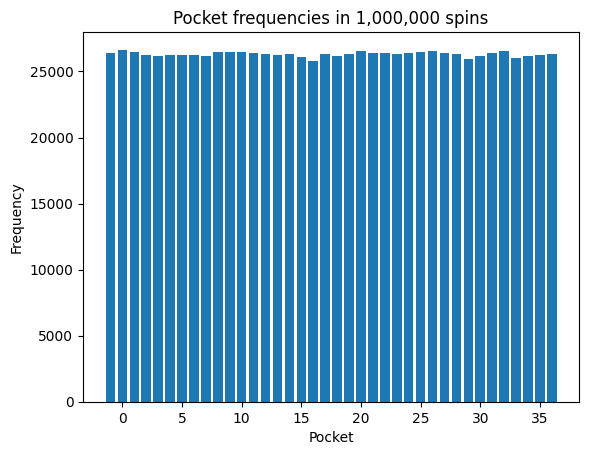

In [569]:
fig, ax = plt.subplots()
ax.bar([pocket[0][0] for pocket in million_spin_frequencies], [pocket[1] for pocket in million_spin_frequencies])
ax.set_title("Pocket frequencies in 1,000,000 spins")
ax.set_xlabel("Pocket")
ax.set_ylabel("Frequency")
plt.show()

That seems relatively uniform to me.

In [570]:
from itertools import zip_longest

In [571]:
class RouletteTable:
    def __init__(self) -> None:
        self.wheel = RouletteWheel()
        self.wheel_history = list()
        self.players = set()
        self.live_players = set()
    
    def add_player(self, player):
        self.players.add(player)
        self.live_players.add(player)
    
    def round(self):
        winning_pocket = self.wheel.spin()
        for player in self.players:
            player.inform(winning_pocket, self.wheel_history)
        self.wheel_history.append(winning_pocket)
    
    def play(self):
        while self.live_players:
            self.round()
            self.live_players = {player for player in self.live_players if player.alive()}
    
    def get_history(self):
        return list(enumerate(zip_longest(self.wheel_history, *[player.get_history() for player in self.players]), start=1))

In [572]:
class AlwaysRed:
    def __init__(self, starting_funds = 100, minimum_bet = 3) -> None:
        self.funds = starting_funds
        self.history = list()
        self.bet = minimum_bet
    
    def inform(self, pocket, table_history):
        number, color = pocket
        bet = min(self.bet, self.funds)
        if color == "red":
            winnings = bet
        else:
            winnings = -bet
        self.funds += winnings
        self.history.append(("AlwaysRed", "red", winnings, self.funds))
    
    def alive(self):
        return self.funds > 0

    def get_history(self):
        return self.history



In [573]:
class AlwaysBlack:
    def __init__(self, starting_funds = 100, minimum_bet = 3) -> None:
        self.funds = starting_funds
        self.history = list()
        self.bet = minimum_bet
    
    def inform(self, pocket, table_history):
        number, color = pocket
        bet = min(self.bet, self.funds)
        if color == "black":
            winnings = bet
        else:
            winnings = -bet
        self.funds += winnings
        self.history.append(("AlwaysBlack", "red", bet, winnings, self.funds))
    
    def alive(self):
        return self.funds > 0

    def get_history(self):
        return self.history



In [574]:
class MartingaleChase:
    def __init__(self, starting_funds = 100, minimum_bet = 3, starting_color = "black", quit_on_loss = False) -> None:
        self.starting_bet = minimum_bet
        self.current_bet = minimum_bet
        self.funds = starting_funds
        self.last_seen_winning_color = starting_color
        self.history = list()
        self.early_quit = quit_on_loss
        self.quit = False
    
    def inform(self, pocket, table_history):
        winning_number, winning_color = pocket
        bet_color = self.last_seen_winning_color
        if (self.early_quit and self.current_bet > self.funds) or self.funds == 0:
            self.quit = True
        bet = min(self.current_bet, self.funds) if not self.quit else 0
        if winning_color == bet_color:
            winnings = bet
            self.current_bet = self.starting_bet
        else:
            winnings = -bet
            self.current_bet += self.current_bet
        self.funds += winnings
        self.history.append(("MartingaleChase", bet_color, bet, winnings, self.funds))
        if winning_color != 'green':
            self.last_seen_winning_color = winning_color
    
    def get_history(self):
        return self.history
    
    def alive(self):
        return not self.quit

In [575]:
class Makeshift:
    def __init__(self, starting_funds = 100, minimum_bet = 3, starting_color = "black", quit_on_loss = False) -> None:
        pass
    
    def inform(self, pocket, table_history):
        pass
    
    def get_history(self):
        pass
    
    def alive(self):
        return not self.quit

In [576]:
def sample_martingale():
    myTable = RouletteTable()
    myTable.add_player(MartingaleChase(quit_on_loss=False))
    myTable.play()
    return len(myTable.get_history())

In [577]:
martingale_samples = tuple(sample_martingale() for _ in range(1_000_000))

In [580]:
import itertools
martingale_frequency_counter = Counter(martingale_samples)
martingale_frequencies = sorted(martingale_frequency_counter.most_common())
martingale_frequencies_normalized = [(rounds, count/len(martingale_samples)) for rounds, count in martingale_frequencies]
martingale_frequencies_cumulative = list(zip([x[0] for x in martingale_frequencies_normalized], itertools.accumulate([x[1] for x in martingale_frequencies_normalized])))
martingale_frequencies_trimmed = [x for x in martingale_frequencies_cumulative if x[1] <= 0.80]


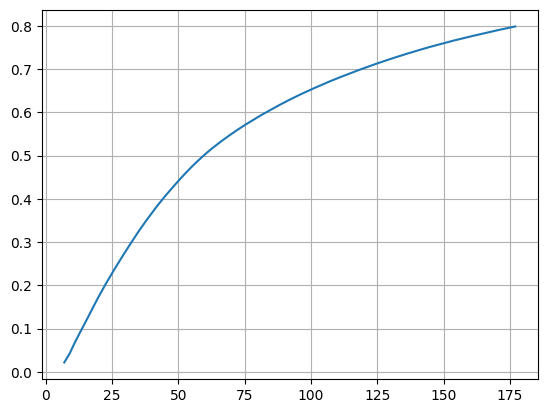

In [581]:
fig, ax = plt.subplots()
ax.plot([x[0] for x in martingale_frequencies_trimmed], [x[1] for x in martingale_frequencies_trimmed])
ax.grid(True)
plt.show()
